# Table of Contents
 <p><div class="lev1"><a href="#Task-1.-Compiling-Ebola-Data"><span class="toc-item-num">Task 1.&nbsp;&nbsp;</span>Compiling Ebola Data</a></div>
 <div class="lev1"><a href="#Task-2.-RNA-Sequences"><span class="toc-item-num">Task 2.&nbsp;&nbsp;</span>RNA Sequences</a></div>
 <div class="lev1"><a href="#Task-3.-Class-War-in-Titanic"><span class="toc-item-num">Task 3.&nbsp;&nbsp;</span>Class War in Titanic</a></div></p>

In [2]:
import pandas as pd
import numpy as np
import glob
%pylab inline
pd.options.mode.chained_assignment = None  # default='warn', Mutes warnings when copying a slice from a DataFrame.

Populating the interactive namespace from numpy and matplotlib


In [3]:
DATA_FOLDER = '' # Use the data folder provided in Tutorial 02 - Intro to Pandas.

## Task 1. Compiling Ebola Data

The `DATA_FOLDER/ebola` folder contains summarized reports of Ebola cases from three countries (Guinea, Liberia and Sierra Leone) during the recent outbreak of the disease in West Africa. For each country, there are daily reports that contain various information about the outbreak in several cities in each country.

Use pandas to import these data files into a single `Dataframe`.
Using this `DataFrame`, calculate for *each country*, the *daily average per month* of *new cases* and *deaths*.
Make sure you handle all the different expressions for *new cases* and *deaths* that are used in the reports.

-------------------

In [4]:
from datetime import datetime

We select all the files for Guinea and we concatenate them into the `eb_guinea DataFrame` 

In [5]:
guinea_files = glob.glob(DATA_FOLDER + 'ebola/guinea_data/*.csv')
eb_guinea = pd.concat((pd.read_csv(guinea_file, parse_dates=['Date']) for guinea_file in guinea_files))

We only select useful columns out of our entire `DataFrame`

In [6]:
eb_guinea_useful = eb_guinea[['Description', 'Date', 'Totals']]

Then we select the rows that we interest to, i.e. all the 'new cases' and all the 'new deaths'

In [7]:
guinea_desc_cond = [desc.startswith('New cases') or desc.startswith('New deaths') for desc in eb_guinea_useful.Description]
eb_guinea_useful = eb_guinea_useful[guinea_desc_cond]

We just retain the month of the date since it is the only thing we care about

In [8]:
eb_guinea_useful['Date'] = eb_guinea_useful.Date.dt.month

The data gets properly indexed and the values are cleaned to be integers without any `NaN` values

In [9]:
eb_guinea_indexed = eb_guinea_useful.set_index(['Description', 'Date']).sort_index()
eb_guinea_clean = eb_guinea_indexed.fillna(0).applymap(lambda x: int(x))

The result is just a `groupby` operation on our current `DataFrame` where we take the mean of all the values we grouped together

In [10]:
eb_guinea_result = eb_guinea_clean.groupby(level=['Description', 'Date']).mean()

The values are rounded to gets a precision of 3 decimals and the column is renamed to have a more accurate name.
The date still has a number (representing the month) as value but this will be cleaned in the last step (i.e. the merging of all `DataFrame`s)

In [11]:
eb_guinea_clean_result = eb_guinea_result.rename(columns={'Totals': 'Daily average'}).round(3)
eb_guinea_clean_result

Daily average
Description                                 Date               
New cases of confirmed                      8            12.400
                                            9            13.000
                                            10            6.000
New cases of confirmed among health workers 8             0.000
                                            9             0.438
                                            10            2.000
New cases of probables                      8             1.600
                                            9             1.188
                                            10            0.000
New cases of suspects                       8            11.800
                                            9             5.438
                                            10           28.000
New deaths registered                       8             3.750
                                            9             3.562
                                            10           15.000
New deaths registered among health workers  8             0.000
                                            9             0.000
                                            10            0.000
New deaths registered today                 8             2.000
New deaths registered today (confirmed)     8             2.000
New deaths registered today (probables)     8             0.000
New deaths registered today (suspects)      8             0.000

----------------

In [12]:
liberia_files = glob.glob(DATA_FOLDER + 'ebola/liberia_data/*.csv')
eb_liberia = pd.concat(pd.read_csv(liberia_file, parse_dates=['Date']) for liberia_file in liberia_files)

We need to change the condition for the descriptions since they are not the same as in the Guinea files

In [13]:
liberia_var_cond = [var.lower().startswith('new case/s') 
                    or ('death' in var.lower() and 'total' not in var.lower()) for var in eb_liberia.Variable]
eb_liberia_useful = eb_liberia[liberia_var_cond]

In [14]:
eb_liberia_useful['Date'] = eb_liberia_useful.Date.dt.month

In [15]:
eb_liberia_indexed = eb_liberia_useful.set_index(['Variable', 'Date'])
eb_liberia_clean = eb_liberia_indexed.fillna(0).applymap(lambda x: int(x))

Here, we also have to sum along the rows since we do not have access to a `'total'` variable

In [16]:
eb_liberia_result = pd.DataFrame(eb_liberia_clean.sum(axis=1)).groupby(level=['Variable', 'Date']).mean()

In [17]:
eb_liberia_clean_result = eb_liberia_result.rename(columns={0: 'Daily average'}).round(3)
eb_liberia_clean_result

Daily average
Variable                     Date               
Cumulative deaths among HCW  6             5.143
                             7            20.636
                             8            97.333
                             9           158.667
                             10          224.077
                             11          318.933
                             12           38.667
New Case/s (Probable)        6             2.286
                             7             7.455
                             8            39.556
                             9            58.667
                             10           35.920
                             11           16.733
                             12         2316.000
New Case/s (Suspected)       6             4.857
                             7             6.000
                             8            24.000
                             9            56.667
                             10           53.160
                             11           35.933
                             12         4086.444
New case/s (confirmed)       6             4.286
                             7             3.636
                             8            10.889
                             9            12.333
                             10            2.600
                             11            5.133
                             12         3860.667
Newly Reported deaths in HCW 6             0.286
                             7             1.091
                             8             2.222
                             9             1.250
                             10            0.120
                             11            0.000
                             12            0.000
Newly reported deaths        6             3.857
                             7             8.545
                             8            46.444
                             9            72.083
                             10           56.160
                             11           27.133
                             12            0.000

---------------------

In [18]:
sl_files = glob.glob(DATA_FOLDER + 'ebola/sl_data/*.csv')
eb_sl = pd.concat(pd.read_csv(sl_file, parse_dates=['date']) for sl_file in sl_files)

In [19]:
sl_var_cond = [var.startswith('new') or var.startswith('death') for var in eb_sl.variable]
eb_sl_useful = eb_sl[sl_var_cond]

This data set still had value once we tried to clean everything, so we use the following function to retain only the data where we get an `int`

In [20]:
def to_int_or_not(x):
    try:
        return int(x)
    except:
        return x

In [21]:
eb_sl_useful['date'] = eb_sl_useful.date.dt.month

We declare a mask so that we retain only the ints and not everything else

In [22]:
eb_sl_indexed = eb_sl_useful.set_index(['variable', 'date'])
eb_sl_tried = eb_sl_indexed.fillna(0).applymap(lambda x: to_int_or_not(x))
eb_sl_clean_mask = eb_sl_tried.applymap(lambda x: isinstance(x, int))
eb_sl_clean = eb_sl_tried[eb_sl_clean_mask]

In [23]:
eb_sl_result = pd.DataFrame(eb_sl_clean.sum(axis=1)).groupby(level=['variable', 'date']).mean()

In [24]:
eb_sl_clean_result = eb_sl_result.rename(columns={0: 'Daily average'}).round(3)

---------------

This last step merges all the `_clean_result Dataframe`s above into a single one. We have to change the name of the different indexes names, and we have to map the month number to its name

In [25]:
import calendar

eb_all_result = pd.concat([eb_guinea_clean_result, eb_liberia_clean_result, eb_sl_clean_result], keys=['Guinea', 'Liberia', 'Sierra Leone'])
eb_all_result.index = eb_all_result.index.set_names(['Country', 'Description', 'Month'])
eb_all_result.index = eb_all_result.index.set_levels(eb_all_result.index.levels[2].map(lambda x: calendar.month_name[x]), level=2)
eb_all_result

Daily average
Country      Description                                 Month                   
Guinea       New cases of confirmed                      August            12.400
                                                         September         13.000
                                                         October            6.000
             New cases of confirmed among health workers August             0.000
                                                         September          0.438
                                                         October            2.000
             New cases of probables                      August             1.600
                                                         September          1.188
                                                         October            0.000
             New cases of suspects                       August            11.800
                                                         September          5.438
                                                         October           28.000
             New deaths registered                       August             3.750
                                                         September          3.562
                                                         October           15.000
             New deaths registered among health workers  August             0.000
                                                         September          0.000
                                                         October            0.000
             New deaths registered today                 August             2.000
             New deaths registered today (confirmed)     August             2.000
             New deaths registered today (probables)     August             0.000
             New deaths registered today (suspects)      August             0.000
Liberia      Cumulative deaths among HCW                 June               5.143
                                                         July              20.636
                                                         August            97.333
                                                         September        158.667
                                                         October          224.077
                                                         November         318.933
                                                         December          38.667
             New Case/s (Probable)                       June               2.286
...                                                                           ...
Sierra Leone new_confirmed                               December          65.200
             new_contacts                                August           359.100
                                                         September        509.448
                                                         October          889.750
                                                         November         499.952
                                                         December         706.800
             new_negative                                October           59.500
                                                         November          68.571
                                                         December          66.400
             new_noncase                                 August            21.400
                                                         September         56.034
                                                         October          109.357
                                                         November         161.857
                                                         December         189.600
             new_positive                                October           53.125
                                                         November          37.476
                                                  

Saving the result to a nice `.csv` file

In [26]:
eb_all_result.to_csv(DATA_FOLDER + 'ebola.csv')

## Task 2. RNA Sequences

In the `DATA_FOLDER/microbiome` subdirectory, there are 9 spreadsheets of microbiome data that was acquired from high-throughput RNA sequencing procedures, along with a 10<sup>th</sup> file that describes the content of each. 

Use pandas to import the first 9 spreadsheets into a single `DataFrame`.
Then, add the metadata information from the 10<sup>th</sup> spreadsheet as columns in the combined `DataFrame`.
Make sure that the final `DataFrame` has a unique index and all the `NaN` values have been replaced by the tag `unknown`.

---------------------------------------------------------------------

First we select and concatenate all the files of the type `MID*.xls` in the data folder. We also add a column named `BARCODE` that gets the value of the file name without the `.xls`. This is done so that it will later match with the metadata file.

In [27]:
data_files = glob.glob(DATA_FOLDER + 'microbiome/MID*.xls')
micro_data = pd.concat(pd.read_excel(data_file, names=['Taxon', 'Number'], header=None).assign(BARCODE=data_file[-8:-4]) for data_file in data_files)
micro_data

,Taxon,Number,BARCODE
0,"Archaea ""Crenarchaeota"" Thermoprotei Desulfuro...",7,MID1
1,"Archaea ""Crenarchaeota"" Thermoprotei Desulfuro...",2,MID1
2,"Archaea ""Crenarchaeota"" Thermoprotei Sulfoloba...",3,MID1
3,"Archaea ""Crenarchaeota"" Thermoprotei Thermopro...",3,MID1
4,"Archaea ""Euryarchaeota"" ""Methanomicrobia"" Meth...",7,MID1
5,"Archaea ""Euryarchaeota"" ""Methanomicrobia"" Meth...",1,MID1
6,"Archaea ""Euryarchaeota"" ""Methanomicrobia"" Meth...",1,MID1
7,"Archaea ""Euryarchaeota"" Archaeoglobi Archaeogl...",1,MID1
8,"Archaea ""Euryarchaeota"" Archaeoglobi Archaeogl...",1,MID1
9,"Archaea ""Euryarchaeota"" Halobacteria Halobacte...",1,MID1


We check that no data is null

In [28]:
micro_data.isnull().any()

Taxon      False
Number     False
BARCODE    False
dtype: bool

We read the last file in a separate `DataFrame`

In [29]:
micro_meta = pd.read_excel(DATA_FOLDER + 'microbiome/metadata.xls').fillna('unknown')
micro_meta

,BARCODE,GROUP,SAMPLE
0,MID1,EXTRACTION CONTROL,unknown
1,MID2,NEC 1,tissue
2,MID3,Control 1,tissue
3,MID4,NEC 2,tissue
4,MID5,Control 2,tissue
5,MID6,NEC 1,stool
6,MID7,Control 1,stool
7,MID8,NEC 2,stool
8,MID9,Control 2,stool


This function is only used to get the final result a little bit nicer to the eye with strings being printed as titles (e.g. `'this string is nicer'` $\rightarrow$ `'This String Is Nicer'`), but it will keep numbers as numbers (which may be useful if we were to reuse this table later on)

In [30]:
def to_title_if_str(s):
    if isinstance(s, str):
        return s.title()
    else:
        return s

The two tables both have a column named `'BARCODE'`, so we can emrge them automatically on this column. Then we change the name of the columns to get capitalized names. The index is set to a unique index which is the barcode and the taxon. Finally, we apply the `to_title_if_str` function to get nice results and we store the result in the `micro_result DataFrame`

In [60]:
micro_merged = micro_meta.merge(micro_data)
micro_merged.columns = [column.capitalize() for column in micro_merged.columns]
micro_result = micro_merged.applymap(to_title_if_str).drop('Barcode', axis=1).set_index(['Sample', 'Group', 'Taxon']).sort_index()

In [61]:
micro_result

Number
Sample  Group              Taxon                                                     
Stool   Control 1          Archaea "Crenarchaeota" Thermoprotei Acidilobal...       1
                           Archaea "Crenarchaeota" Thermoprotei Desulfuroc...       8
                           Archaea "Crenarchaeota" Thermoprotei Desulfuroc...       2
                           Archaea "Crenarchaeota" Thermoprotei Desulfuroc...       1
                           Archaea "Crenarchaeota" Thermoprotei Desulfuroc...       1
                           Archaea "Crenarchaeota" Thermoprotei Desulfuroc...       1
                           Archaea "Crenarchaeota" Thermoprotei Sulfolobal...       5
                           Archaea "Crenarchaeota" Thermoprotei Sulfolobal...       3
                           Archaea "Crenarchaeota" Thermoprotei Thermoprot...       5
                           Archaea "Euryarchaeota" "Methanomicrobia" Metha...      18
                           Archaea "Euryarchaeota" "Methanomicrobia" Metha...       1
                           Archaea "Euryarchaeota" "Methanomicrobia" Metha...       1
                           Archaea "Euryarchaeota" "Methanomicrobia" Metha...       2
                           Archaea "Euryarchaeota" "Methanomicrobia" Metha...       2
                           Archaea "Euryarchaeota" Archaeoglobi Archaeoglo...       9
                           Archaea "Euryarchaeota" Archaeoglobi Archaeoglo...       2
                           Archaea "Euryarchaeota" Halobacteria Halobacter...       3
                           Archaea "Euryarchaeota" Halobacteria Halobacter...       2
                           Archaea "Euryarchaeota" Halobacteria Halobacter...       6
                           Archaea "Euryarchaeota" Halobacteria Halobacter...       4
                           Archaea "Euryarchaeota" Methanobacteria Methano...       1
                           Archaea "Euryarchaeota" Methanococci Methanococ...       1
                           Archaea "Euryarchaeota" Methanopyri Methanopyra...      59
                           Archaea "Euryarchaeota" Thermoplasmata Thermopl...      10
                           Bacteria "Acidobacteria" Holophagae Holophagale...       1
                           Bacteria "Actinobacteria" Actinobacteria  Acidi...     102
                           Bacteria "Actinobacteria" Actinobacteria Acidim...       1
                           Bacteria "Actinobacteria" Actinobacteria Acidim...       5
                           Bacteria "Actinobacteria" Actinobacteria Acidim...       3
                           Bacteria "Actinobacteria" Actinobacteria Actino...       3
...                                                                               ...
Unknown Extraction Control Bacteria "Proteobacteria" Gammaproteobacteria O...       1
                           Bacteria "Proteobacteria" Gammaproteobacteria O...       1
                           Bacteria "Proteobacteria" Gammaproteobacteria P...      11
                           Bacteria "Proteobacteria" Gammaproteobacteria P...       9
                           Bacteria "Proteobacteria" Gammaproteobacteria P...       1
                           Bacteria "Proteobacteria" Gammaproteobacteria P...     396
                           Bacteria "Proteobacteria" Gammaproteobacteria P...     414
                           Bacteria "Proteobacteria" Gammaproteobacteria P...    3732
                           Bacteria "Proteobacteria" Gammaproteobacteria T...       4
                           Bacteria "Proteobacteria" Gammaproteobacteria T...      22
                           Bacteria "Proteobacteria" Gammaproteobacteria T...       1
                           Bacteria "Proteobacteria" Gammaproteobacteria T...       4
                           Bacteria "Proteobacteria" Gammaproteobacteria X...       5
                           Bacteria "Proteobacteria" Gammaproteobacteria X...       6
                           Bacteria "

Saving the result to a nice `.xls` file

In [33]:
micro_result.to_excel(DATA_FOLDER + 'microbiome.xls')

## Task 3. Class War in Titanic

Use pandas to import the data file `Data/titanic.xls`. It contains data on all the passengers that travelled on the Titanic.

In [34]:
from IPython.core.display import HTML
HTML(filename=DATA_FOLDER+'titanic.html')

Name,Labels,Units,Levels,Storage,NAs
pclass,,,3,integer,0
survived,Survived,,,double,0
name,Name,,,character,0
sex,,,2,integer,0
age,Age,Year,,double,263
sibsp,Number of Siblings/Spouses Aboard,,,double,0
parch,Number of Parents/Children Aboard,,,double,0
ticket,Ticket Number,,,character,0
fare,Passenger Fare,British Pound (\243),,double,1
cabin,,,187,integer,0


For each of the following questions state clearly your assumptions and discuss your findings:
1. Describe the *type* and the *value range* of each attribute. Indicate and transform the attributes that can be `Categorical`. 
2. Plot histograms for the *travel class*, *embarkation port*, *sex* and *age* attributes. For the latter one, use *discrete decade intervals*. 
3. Calculate the proportion of passengers by *cabin floor*. Present your results in a *pie chart*.
4. For each *travel class*, calculate the proportion of the passengers that survived. Present your results in *pie charts*.
5. Calculate the proportion of the passengers that survived by *travel class* and *sex*. Present your results in *a single histogram*.
6. Create 2 equally populated *age categories* and calculate survival proportions by *age category*, *travel class* and *sex*. Present your results in a `DataFrame` with unique index.

In [63]:
titanic = pd.read_excel(DATA_FOLDER+'titanic.xls', sheetname='titanic')


#### Task 3.1

The titanic DataFrame is composed of either Objects or int/float types. We can verify this with the following array :

In [36]:
[titanic[c].dtype for c in titanic.columns]

[dtype('int64'),
 dtype('int64'),
 dtype('O'),
 dtype('O'),
 dtype('float64'),
 dtype('int64'),
 dtype('int64'),
 dtype('O'),
 dtype('float64'),
 dtype('O'),
 dtype('O'),
 dtype('O'),
 dtype('float64'),
 dtype('O')]

Then we can easily find the maximum and minimums of relevant attributes, aka numerical ones with the describe method :

In [37]:
desc = titanic.describe()
minmax = [(v == 'min') or (v == 'max') for v in desc.index]
desc.loc[minmax]

,pclass,survived,age,sibsp,parch,fare,body
min,1.0,0.0,0.1667,0.0,0.0,0.0000,1.0
max,3.0,1.0,80.0000,8.0,9.0,512.3292,328.0


The attributes that can be made Categorical are **pclass**, **sex**, **cabin**, **embarkment**, since they have a limited amount of fixed values for each passenger.

In [64]:
titanic.pclass=titanic.pclass.astype('category')
titanic.sex=titanic.sex.astype('category')
titanic.cabin=titanic.cabin.astype('category')
titanic.embarked=titanic.embarked.astype('category')


#### Task 3.2

Histogram of the travel class repartition : 

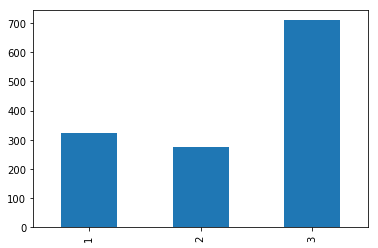

In [39]:
titanic.pclass.value_counts().sort_index().plot(kind='bar')

Histogram of the embarkation port repartition :

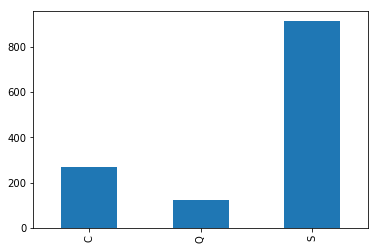

In [40]:
titanic.embarked.value_counts().sort_index().plot(kind='bar')

Histogram of the sex repartition :

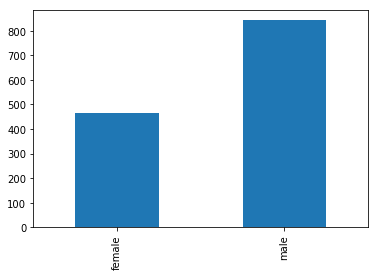

In [41]:
titanic.sex.value_counts().sort_index().plot(kind='bar')

Concerning the age attribute, we separate the values in decade intervals, and plot those intervals as a Histogram :

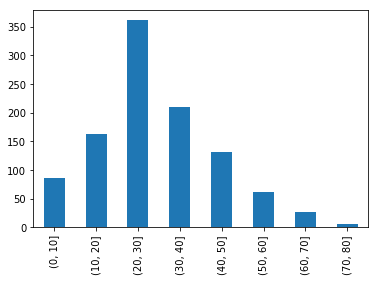

In [42]:
titanic_age=pd.cut(titanic.age.fillna(0), [0,10,20,30,40,50,60,70,80])

titanic_age.value_counts().sort_index().plot(kind='bar')
#titanic.age.value_counts().plot(kind='bar')

#### Task 3.3

For this subtask, we will keep the first letter of the cabin number which is the actual cabin floor. Even for the cabines that are of the shape "F G73", F represents the deck and G represent the section on that deck

In [156]:
def trycab(x):
    if x=="Unknown":
        return x
    else:
        return x[0]

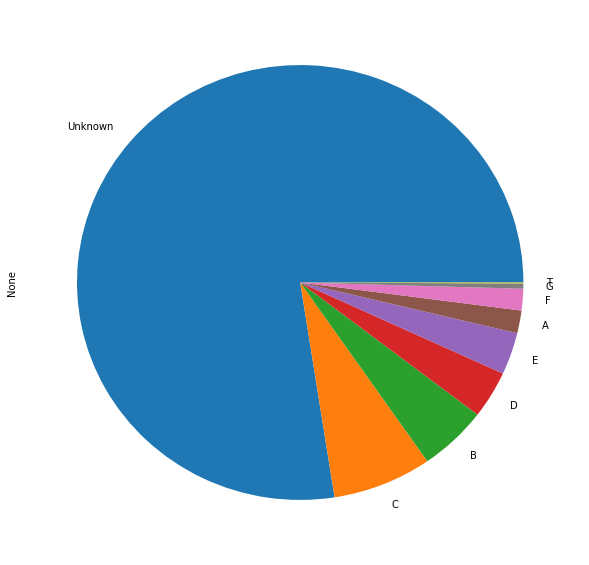

In [157]:
titanic_cab = titanic.cabin.cat.add_categories("Unknown")
titanic_cab = titanic_cab.fillna("Unknown").map(lambda x:trycab(x))
v = titanic_cab.value_counts()

v.plot.pie(figsize=(10, 10))

We see that we don't know the cabin's floor of most of the passengers. Our explanation is that most of the people that died where on one of the lowest Deck of the boat i.e. Deck E, F, G in third class, so that we couldn't retrieve their Deck informations.


#### Task 3.4

Now let's find the proportion of passengers that survived per class.

In [45]:
def map_survived(a):
    if int(a) == 0:
        return 'died'
    else:
        return 'survived'

In [46]:
interesting = titanic[['pclass', 'survived']]

In [47]:
interesting['survived'] = interesting.survived.map(map_survived)
interesting = interesting.rename(columns={'survived': 'status'})

In [48]:
interesting = interesting.rename(columns={'survived': 'status'})

In [49]:
count = interesting.groupby(by=['pclass'])['status'].value_counts().sort_index()
count

pclass  status  
1       died        123
        survived    200
2       died        158
        survived    119
3       died        528
        survived    181
Name: status, dtype: int64

Plotting the graph 

Index(['died', 'survived'], dtype='object', name='status')

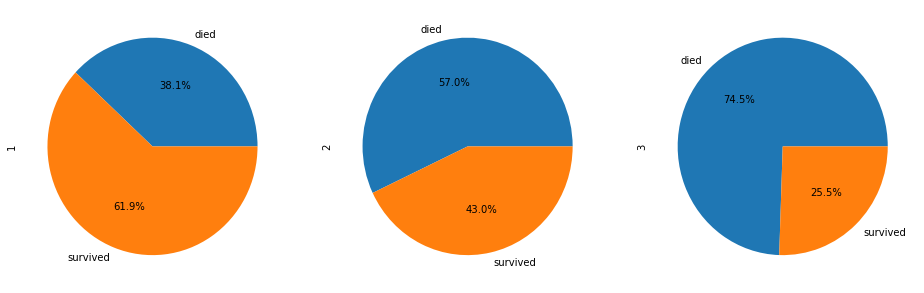

In [50]:
count.unstack(level=0).plot.pie(subplots=True, figsize=(16, 5), autopct='%1.1f%%', legend=False)
count.index.levels[1]

We can confirm here our hypothesis that the passengers in the third class were most likely to die

#### Task 3.5

Let's begin by reshaping and selecting useful information

In [82]:
titPclassSexSurv = titanic.groupby(by=["pclass","sex"])["survived"].value_counts().unstack("survived")
titPclassSexSurv

survived         0    1
pclass sex             
1      female    5  139
       male    118   61
2      female   12   94
       male    146   25
3      female  110  106
       male    418   75

Now that we have a nice and cleaned DataFrame with only the useful data, we still have to compute de percentage of passengers that survived and plot the histogram

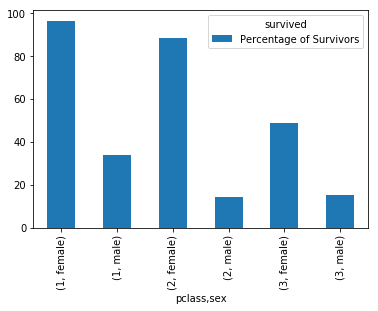

In [53]:
titPclassSexSurv['Percentage of Survivors']=100*titPclassSexSurv[1]/(titPclassSexSurv[0]+titPclassSexSurv[1])
titPclassSexSurv = titPclassSexSurv.drop([0,1], axis=1)
titPclassSexSurv.plot(kind="bar")

As we could excpect, women were more likely to survive than men. Indeed, *women and children first!* Even the third class women were more likely to survive than the first class men. Another interessting fact is that even if the percentage of women that survives drop drastically between the second and the third class, for the men case, we notice a litlle increase.

In [54]:
titPclassSexSurv.loc[[(2,'male')]]

,survived,Percentage of Survivors
pclass,sex,
2,male,14.619883


In [55]:
titPclassSexSurv.loc[[(3,'male')]]

,survived,Percentage of Survivors
pclass,sex,
3,male,15.212982



##### Task 3.6

In [205]:
#Useful for sorting the ages according to the median
def catego(x,med):
    if x<med:
        return "young (<"+str(med)+")"
    else:
        return"old (>="+str(med)+")"

First let's work on copy of the original data frame in order to keep it intact and keep just what we need

In [206]:
titanic_age_sep = titanic.copy()
titanic_age_sep = titanic_age_sep[["age", "survived","sex","pclass"]]
titanic_age_sep = titanic_age_sep.dropna()

Now we calculate the mediane and create 2 categorizes one above and the other one under the median

In [207]:
med = titanic_age_sep.age.median()
titanic_age_sep["age"] = titanic_age_sep['age'].map(lambda x: catego(x,med))

We arrange here our `Dataframe`, compute the percentage and plot our histogram

In [208]:
titanic_age_sep = titanic_age_sep.groupby(by=["age","pclass","sex"])["survived"].value_counts().unstack("survived")



titanic_age_sep["Percentage of suvivors"] = 100*titanic_age_sep[1]/(titanic_age_sep[0]+titanic_age_sep[1])
titanic_age_sep = titanic_age_sep.drop([0,1], axis=1)
titanic_age_sep

survived                     Percentage of suvivors
age           pclass sex                           
old (>=28.0)  1      female               96.774194
                     male                 30.894309
              2      female               88.461538
                     male                  7.777778
              3      female               34.782609
                     male                 13.043478
young (<28.0) 1      female               95.000000
                     male                 53.571429
              2      female               90.196078
                     male                 23.529412
              3      female               52.830189
                     male                 19.431280

As we said before *Women and children first*, that's certainly why the young people were more likely to survive.